In [ ]:
!pip install ultralytics transformers torch opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.4 MB/s eta 0:00:00


## Add qwen-vl

In [ ]:
!pip install qwen_vl_utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 16.6 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login

login(token="")

In [ ]:
import cv2
import torch
import numpy as np
from pathlib import Path
from ultralytics import YOLO
from huggingface_hub import hf_hub_download
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from collections import defaultdict
from scipy.optimize import linear_sum_assignment
import os

cigarette_model_path = hf_hub_download(
    repo_id="Enos-123/smoking-detection",
    filename="best.pt"
)
cigarette_model = YOLO(cigarette_model_path)

smoke_model_path = hf_hub_download(
    repo_id="TommyNgx/YOLOv10-Fire-and-Smoke-Detection",
    filename="best.pt"
)
smoke_model = YOLO(smoke_model_path)

vl_model = Qwen3VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen3-VL-2B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="cuda"
)
vl_processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-2B-Instruct")

input_dir = Path('smoking')
output_dir = Path('smoking/detected')
output_dir.mkdir(exist_ok=True)

In [ ]:


def split_frame_into_quadrants(frame):
    h, w = frame.shape[:2]
    half_h, half_w = h // 2, w // 2

    quadrants = [
        frame[0:half_h, 0:half_w],
        frame[0:half_h, half_w:w],
        frame[half_h:h, 0:half_w],
        frame[half_h:h, half_w:w]
    ]

    offsets = [
        (0, 0),
        (half_w, 0),
        (0, half_h),
        (half_w, half_h)
    ]

    return quadrants, offsets, (half_w, half_h)

def scale_detections_to_original(detections, offset, scale_factor):
    if detections is None or len(detections) == 0:
        return []

    scaled_boxes = []
    for det in detections:
        boxes = det.boxes
        if boxes is not None and len(boxes) > 0:
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

                x1_orig = (x1 / scale_factor) + offset[0]
                y1_orig = (y1 / scale_factor) + offset[1]
                x2_orig = (x2 / scale_factor) + offset[0]
                y2_orig = (y2 / scale_factor) + offset[1]

                conf = box.conf[0].cpu().numpy()
                cls = box.cls[0].cpu().numpy()

                scaled_boxes.append({
                    'box': [x1_orig, y1_orig, x2_orig, y2_orig],
                    'conf': float(conf),
                    'cls': int(cls)
                })

    return scaled_boxes

def compute_iou(box1, box2):
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    xi1 = max(x1_1, x1_2)
    yi1 = max(y1_1, y1_2)
    xi2 = min(x2_1, x2_2)
    yi2 = min(y2_1, y2_2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - inter_area

    if union_area == 0:
        return 0.0
    return inter_area / union_area

def compute_distance(box1, box2):
    cx1 = (box1[0] + box1[2]) / 2
    cy1 = (box1[1] + box1[3]) / 2
    cx2 = (box2[0] + box2[2]) / 2
    cy2 = (box2[1] + box2[3]) / 2
    return np.sqrt((cx1 - cx2)**2 + (cy1 - cy2)**2)

In [ ]:
video_files

[]

In [ ]:
def verify_smoking_with_vl(frame, boxes, batch_size=8):
    if len(boxes) == 0:
        return []

    images = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(frame.shape[1], x2), min(frame.shape[0], y2)

        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            images.append(None)
            continue
        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        from PIL import Image
        pil_image = Image.fromarray(crop_rgb)
        images.append(pil_image)

    results = []
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i+batch_size]
        valid_images = [img for img in batch_images if img is not None]

        if not valid_images:
            results.extend([False] * len(batch_images))
            continue

        messages_batch = []
        for img in valid_images:
            messages_batch.append([{
                "role": "user",
                "content": [
                    {"type": "image", "image": img},
                    {"type": "text", "text": "Is this person smoking a cigarette or vape? Be careful not to confuse phones or bottles with cigarettes. Answer only Yes or No."}
                ]
            }])

        try:
            batch_results = []
            for messages in messages_batch:
                text = vl_processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
                image_inputs, _ = process_vision_info(messages)
                inputs = vl_processor(text=[text], images=image_inputs, padding=True, return_tensors="pt")
                inputs = {k: v.to("cuda") for k, v in inputs.items()}

                with torch.no_grad():
                    generated_ids = vl_model.generate(**inputs, max_new_tokens=10)
                    generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs["input_ids"], generated_ids)]
                    output_text = vl_processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0].strip().lower()

                    batch_results.append("yes" in output_text)

            for j, img in enumerate(batch_images):
                if img is None:
                    results.append(False)
                else:
                    results.append(batch_results.pop(0))

        except Exception as e:
            print(f"VL verification error: {e}")
            results.extend([True] * len(batch_images))

    return results

In [ ]:
class DetectionTracker:
    def __init__(self, max_age=15, min_hits=3, iou_threshold=0.3, distance_threshold=50):
        self.max_age = max_age
        self.min_hits = min_hits
        self.iou_threshold = iou_threshold
        self.distance_threshold = distance_threshold
        self.tracks = []
        self.next_id = 0

    def update(self, detections):
        if len(self.tracks) == 0:
            for det in detections:
                self.tracks.append({
                    'id': self.next_id,
                    'box': det['box'],
                    'conf': det['conf'],
                    'cls': det['cls'],
                    'age': 0,
                    'hits': 1,
                    'conf_history': [det['conf']]
                })
                self.next_id += 1
            return self.tracks

        if len(detections) == 0:
            for track in self.tracks:
                track['age'] += 1
            self.tracks = [t for t in self.tracks if t['age'] < self.max_age]
            return self.tracks

        iou_matrix = np.zeros((len(self.tracks), len(detections)))
        for i, track in enumerate(self.tracks):
            for j, det in enumerate(detections):
                iou = compute_iou(track['box'], det['box'])
                dist = compute_distance(track['box'], det['box'])
                if dist < self.distance_threshold:
                    iou_matrix[i, j] = iou

        row_ind, col_ind = linear_sum_assignment(-iou_matrix)

        matched_tracks = set()
        matched_dets = set()

        for i, j in zip(row_ind, col_ind):
            if iou_matrix[i, j] > self.iou_threshold:
                self.tracks[i]['box'] = detections[j]['box']
                self.tracks[i]['conf'] = detections[j]['conf']
                self.tracks[i]['cls'] = detections[j]['cls']
                self.tracks[i]['age'] = 0
                self.tracks[i]['hits'] += 1
                self.tracks[i]['conf_history'].append(detections[j]['conf'])
                if len(self.tracks[i]['conf_history']) > 10:
                    self.tracks[i]['conf_history'].pop(0)
                matched_tracks.add(i)
                matched_dets.add(j)

        for i, track in enumerate(self.tracks):
            if i not in matched_tracks:
                track['age'] += 1

        for j, det in enumerate(detections):
            if j not in matched_dets:
                self.tracks.append({
                    'id': self.next_id,
                    'box': det['box'],
                    'conf': det['conf'],
                    'cls': det['cls'],
                    'age': 0,
                    'hits': 1,
                    'conf_history': [det['conf']]
                })
                self.next_id += 1

        self.tracks = [t for t in self.tracks if t['age'] < self.max_age]
        return [t for t in self.tracks if t['hits'] >= self.min_hits]

In [ ]:
for video_path in video_files:
    print(f'Processing: {video_path.name}')

    cap = cv2.VideoCapture(str(video_path))

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    output_path = output_dir / f'detected_{video_path.name}'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))

    frame_count = 0
    scale_factor = 2.0
    tracker = DetectionTracker()
    vl_check_interval = 30
    verified_tracks = {}

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        quadrants, offsets, quad_size = split_frame_into_quadrants(frame)

        all_cigarette_detections = []
        all_smoke_detections = []

        for quad_idx, (quadrant, offset) in enumerate(zip(quadrants, offsets)):
            upscaled = cv2.resize(quadrant, None, fx=scale_factor, fy=scale_factor,
                                 interpolation=cv2.INTER_CUBIC)

            cig_results = cigarette_model(upscaled, conf=0.2, verbose=False)
            smoke_results = smoke_model(upscaled, conf=0.2, verbose=False)

            cig_dets = scale_detections_to_original(cig_results, offset, scale_factor)
            smoke_dets = scale_detections_to_original(smoke_results, offset, scale_factor)

            all_cigarette_detections.extend(cig_dets)
            all_smoke_detections.extend(smoke_dets)

        merged_detections = []
        for cig_det in all_cigarette_detections:
            has_smoke_overlap = False
            max_smoke_iou = 0

            for smoke_det in all_smoke_detections:
                iou = compute_iou(cig_det['box'], smoke_det['box'])
                if iou > 0.1:
                    has_smoke_overlap = True
                    max_smoke_iou = max(max_smoke_iou, iou)

            boost_factor = 1.0
            if has_smoke_overlap:
                boost_factor = 1.0 + (0.3 * max_smoke_iou)

            merged_conf = min(cig_det['conf'] * boost_factor, 1.0)

            merged_detections.append({
                'box': cig_det['box'],
                'conf': merged_conf,
                'cls': cig_det['cls'],
                'has_smoke': has_smoke_overlap
            })

        tracked_detections = tracker.update(merged_detections)

        for track in tracked_detections:
            if 'has_smoke' not in track:
                track['has_smoke'] = False

        if frame_count % vl_check_interval == 0 and len(tracked_detections) > 0:
            boxes_to_verify = [t['box'] for t in tracked_detections if t['id'] not in verified_tracks]

            if boxes_to_verify:
                verification_results = verify_smoking_with_vl(frame, boxes_to_verify)

                idx = 0
                for track in tracked_detections:
                    if track['id'] not in verified_tracks:
                        verified_tracks[track['id']] = verification_results[idx]
                        idx += 1

        annotated_frame = frame.copy()
        for track in tracked_detections:
            is_verified = verified_tracks.get(track['id'], True)

            if not is_verified:
                continue

            x1, y1, x2, y2 = map(int, track['box'])
            conf = track['conf']
            avg_conf = np.mean(track['conf_history'])

            temporal_boost = min(track['hits'] / 10.0, 0.2)
            final_conf = min(avg_conf + temporal_boost, 1.0)

            color = (0, 255, 0) if track['has_smoke'] else (0, 255, 255)
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)

            label = f'ID:{track["id"]} {final_conf:.2f}'
            if track['has_smoke']:
                label += ' +smoke'

            label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.rectangle(annotated_frame, (x1, y1 - label_size[1] - 10),
                          (x1 + label_size[0], y1), color, -1)
            cv2.putText(annotated_frame, label, (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        out.write(annotated_frame)
        frame_count += 1

        if frame_count % 30 == 0:
            print(f'  Processed {frame_count} frames, active tracks: {len(tracked_detections)}')

    cap.release()
    out.release()

    print(f'Saved to: {output_path}')

cv2.destroyAllWindows()
print('All videos processed!')

In [ ]:
!pip install open-clip-torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00


In [ ]:
import open_clip
from PIL import Image
import torch.nn.functional as F

clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    'RN50',
    pretrained='openai'
)
clip_model = clip_model.to('cuda')
clip_model.eval()

tokenizer = open_clip.get_tokenizer('RN50')
text_inputs = tokenizer(["cigarette", "vape", "smoking", "phone", "bottle"]).to('cuda')

with torch.no_grad():
    text_features = clip_model.encode_text(text_inputs)
    text_features = F.normalize(text_features, dim=-1)


open_clip_model.safetensors:   0%|          | 0.00/408M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [ ]:
def verify_smoking_with_clip(frame, boxes, threshold=0.25, expand_factor=6, debug=False):
    if len(boxes) == 0:
        return []

    h_img, w_img = frame.shape[:2]
    results = []

    for idx, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)

        bw = x2 - x1
        bh = y2 - y1

        cx = x1 + bw / 2
        cy = y1 + bh / 2

        new_bw = bw * expand_factor
        new_bh = bh * expand_factor

        new_x1 = int(cx - new_bw / 2)
        new_y1 = int(cy - new_bh / 2)
        new_x2 = int(cx + new_bw / 2)
        new_y2 = int(cy + new_bh / 2)

        new_x1 = max(0, new_x1)
        new_y1 = max(0, new_y1)
        new_x2 = min(w_img, new_x2)
        new_y2 = min(h_img, new_y2)

        crop = frame[new_y1:new_y2, new_x1:new_x2]
        if crop.size == 0:
            results.append(False)
            continue

        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(crop_rgb)

        image_input = clip_preprocess(pil_image).unsqueeze(0).to('cuda')

        with torch.no_grad():
            image_features = clip_model.encode_image(image_input)
            image_features = F.normalize(image_features, dim=-1)

            similarity = (image_features @ text_features.T).squeeze(0)

            smoking_scores = similarity[:3]
            non_smoking_scores = similarity[3:]

            max_smoking = smoking_scores.max().item()
            max_non_smoking = non_smoking_scores.max().item()

            is_smoking = (max_smoking > threshold) and (max_smoking > max_non_smoking)
            results.append(is_smoking)

            if debug:
                labels = ["cigarette", "vape", "smoking", "phone", "bottle"]
                import matplotlib.pyplot as plt

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                ax1.imshow(crop_rgb)
                ax1.set_title(f'Expanded box {idx} ×{expand_factor}')
                ax1.axis('off')

                bars = ax2.bar(labels, similarity.cpu().numpy())
                ax2.axhline(threshold, color="green", linestyle="--")
                ax2.set_title(f"Smoking: {max_smoking:.3f}, Non-smoking: {max_non_smoking:.3f}, Verified: {is_smoking}")
                ax2.set_ylim([0, 1])

                for bar, val in zip(bars, similarity.cpu().numpy()):
                    ax2.text(bar.get_x() + bar.get_width()/2., val, f'{val:.3f}', ha='center', va='bottom')

                plt.tight_layout()
                plt.show()

                print(f"Box {idx}: Max smoking={max_smoking:.3f}, Max non-smoking={max_non_smoking:.3f}, Verified: {is_smoking}")

    return results


In [ ]:
video_files = list(input_dir.glob('*.mp4'))
video_files

[PosixPath('smoking/16.mp4')]

Processing: 16.mp4


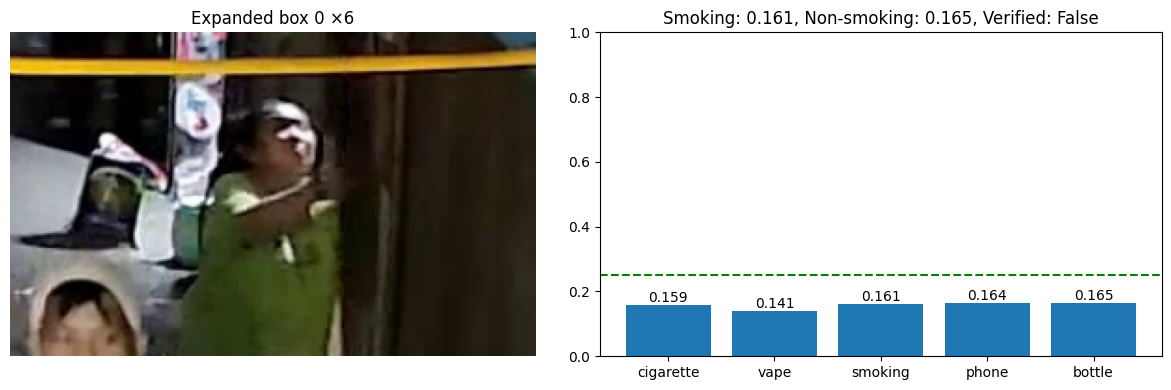

Box 0: Max smoking=0.161, Max non-smoking=0.165, Verified: False
  Processed 30 frames, active tracks: 4


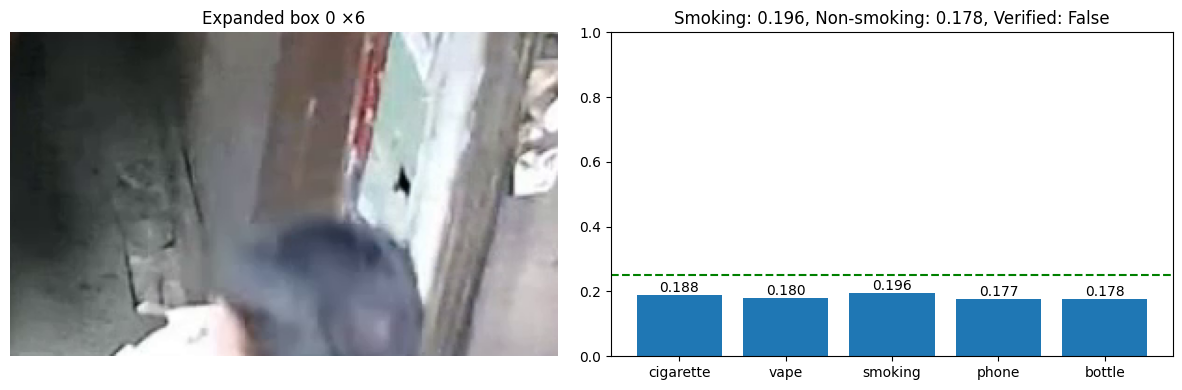

Box 0: Max smoking=0.196, Max non-smoking=0.178, Verified: False


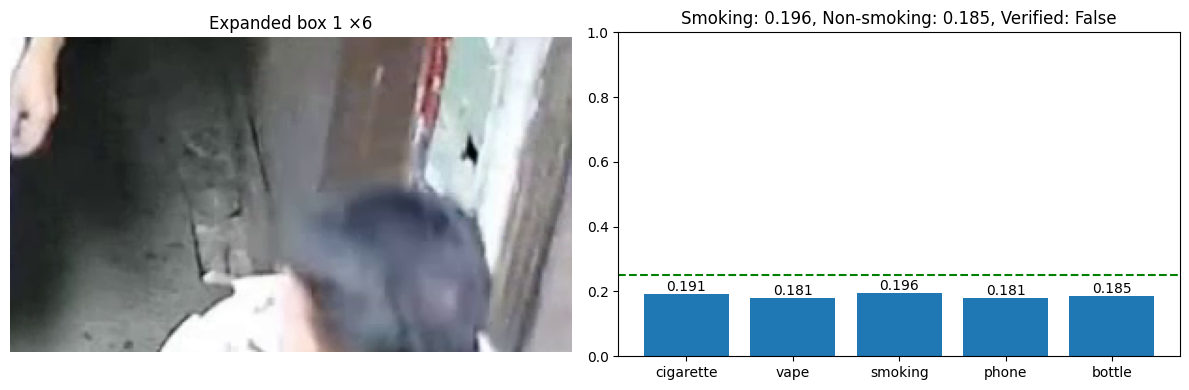

Box 1: Max smoking=0.196, Max non-smoking=0.185, Verified: False


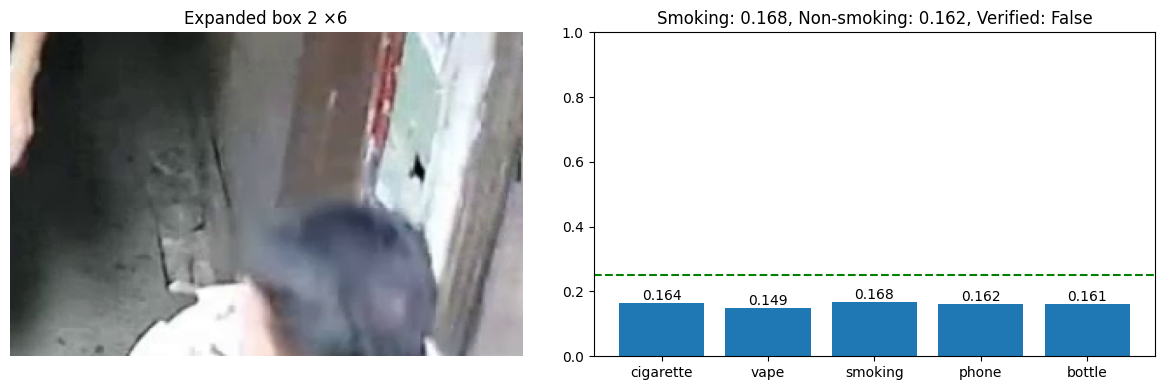

Box 2: Max smoking=0.168, Max non-smoking=0.162, Verified: False


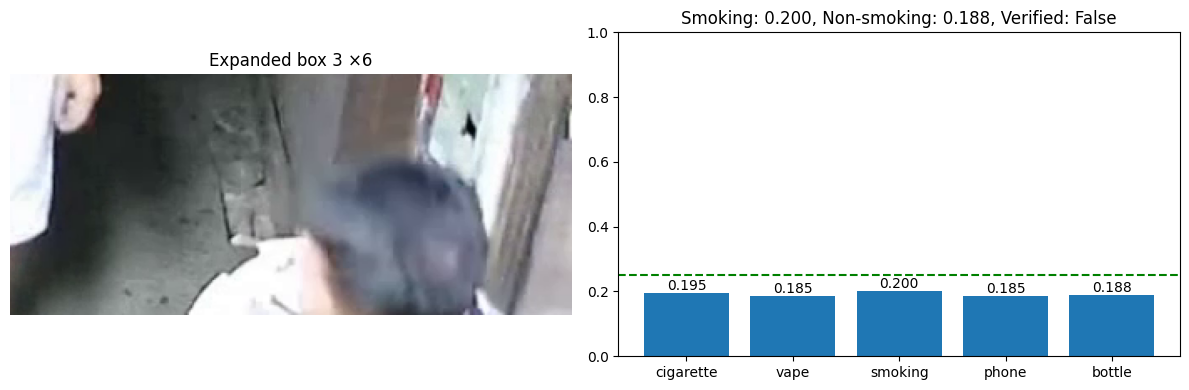

Box 3: Max smoking=0.200, Max non-smoking=0.188, Verified: False
  Processed 60 frames, active tracks: 0
  Processed 90 frames, active tracks: 0
  Processed 120 frames, active tracks: 1


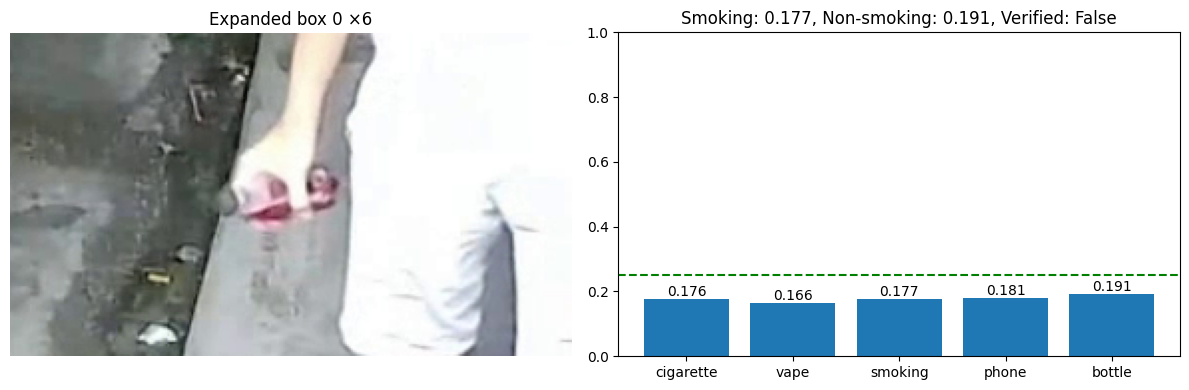

Box 0: Max smoking=0.177, Max non-smoking=0.191, Verified: False
  Processed 150 frames, active tracks: 0


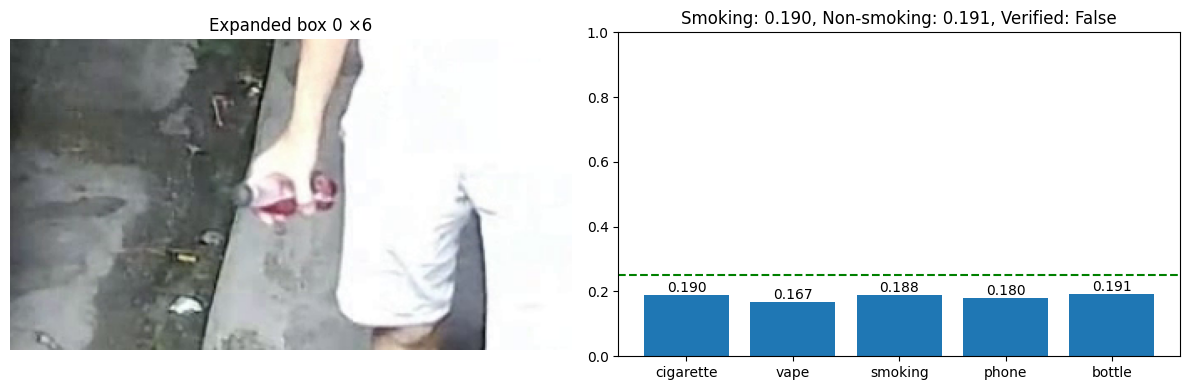

Box 0: Max smoking=0.190, Max non-smoking=0.191, Verified: False


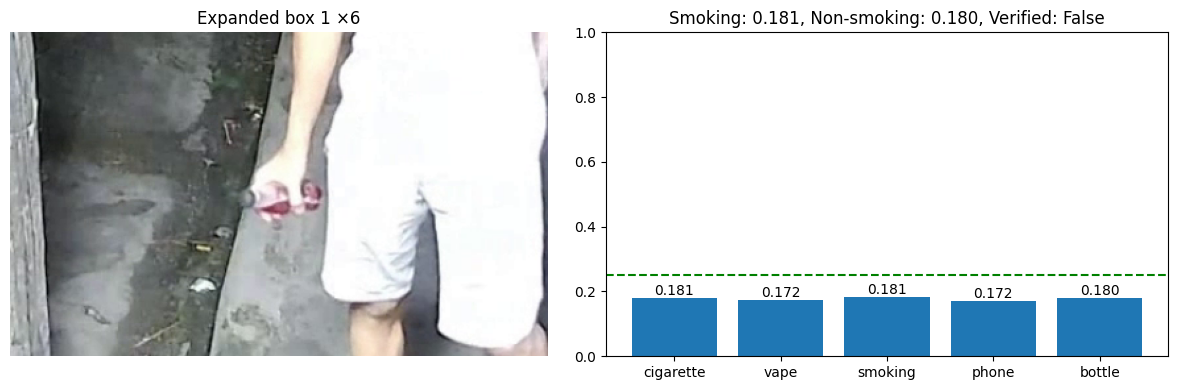

Box 1: Max smoking=0.181, Max non-smoking=0.180, Verified: False
  Processed 180 frames, active tracks: 1
  Processed 210 frames, active tracks: 0
  Processed 240 frames, active tracks: 0
  Processed 270 frames, active tracks: 2


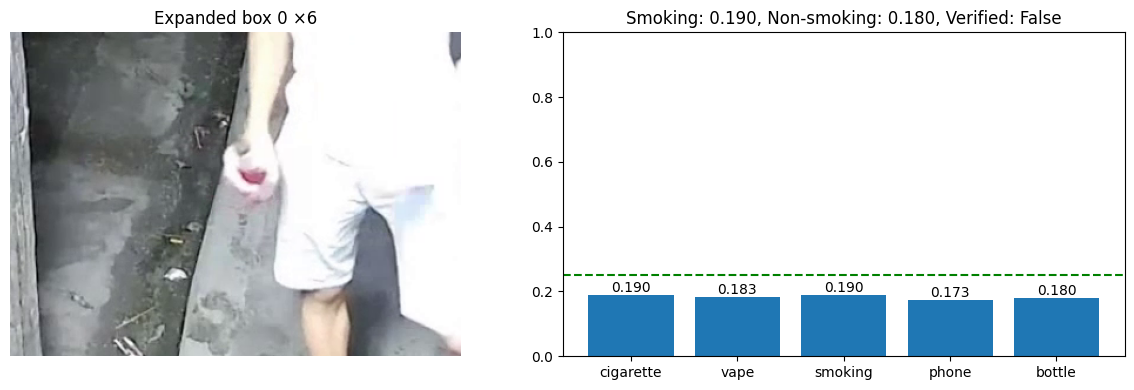

Box 0: Max smoking=0.190, Max non-smoking=0.180, Verified: False


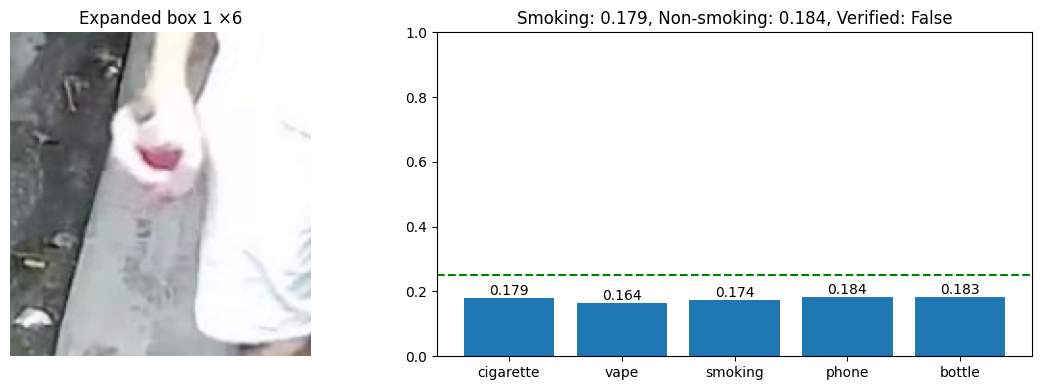

Box 1: Max smoking=0.179, Max non-smoking=0.184, Verified: False
  Processed 300 frames, active tracks: 1


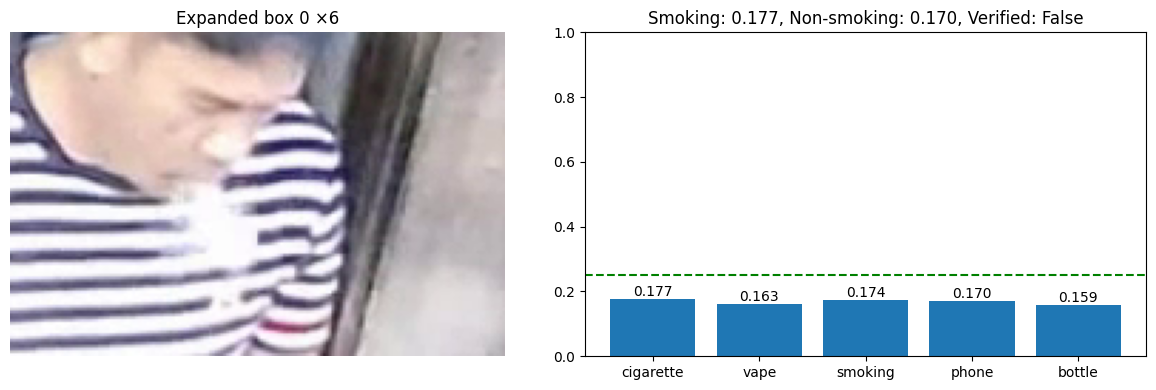

Box 0: Max smoking=0.177, Max non-smoking=0.170, Verified: False
  Processed 330 frames, active tracks: 5


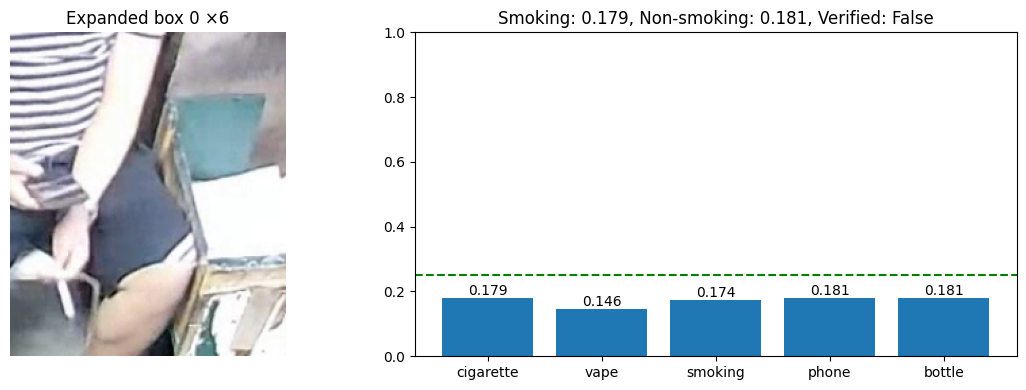

Box 0: Max smoking=0.179, Max non-smoking=0.181, Verified: False


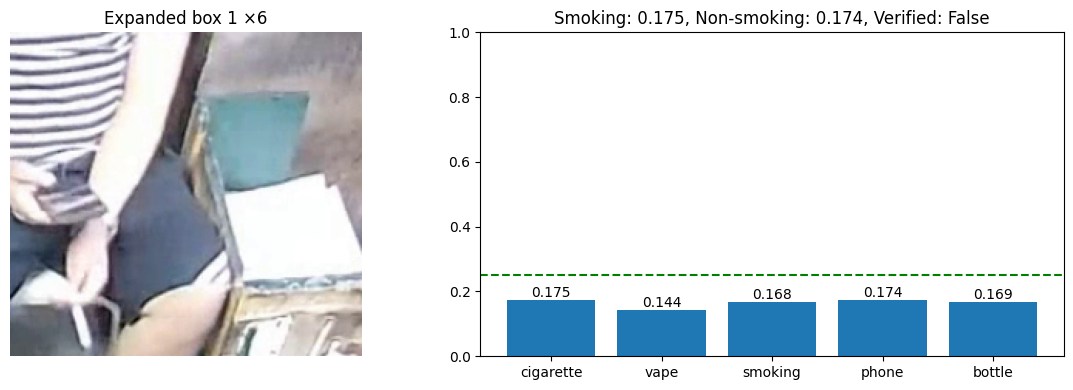

Box 1: Max smoking=0.175, Max non-smoking=0.174, Verified: False


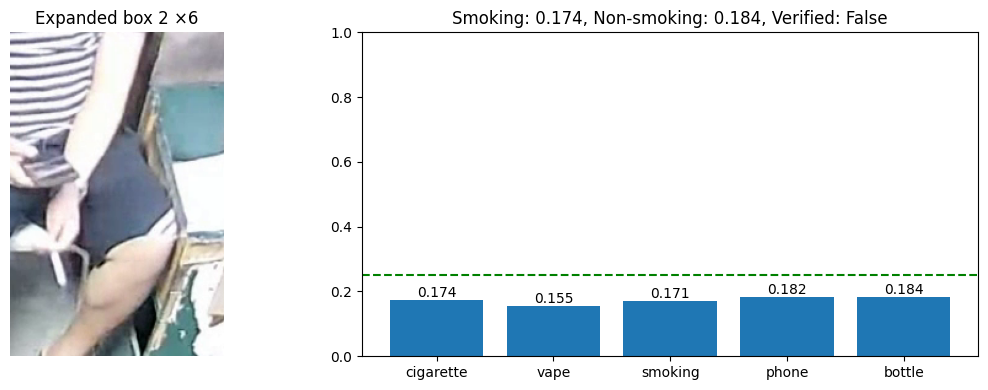

Box 2: Max smoking=0.174, Max non-smoking=0.184, Verified: False


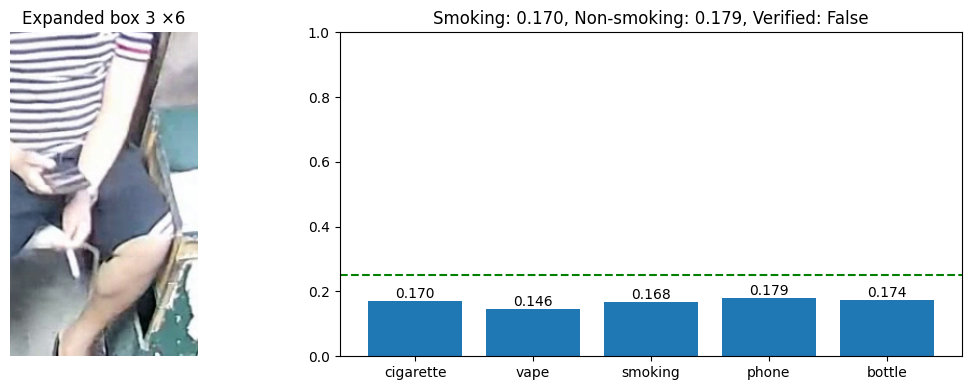

Box 3: Max smoking=0.170, Max non-smoking=0.179, Verified: False


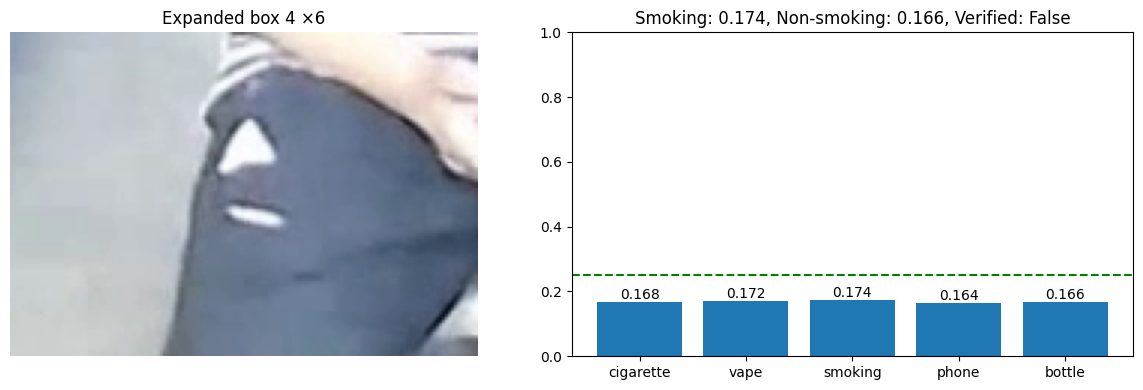

Box 4: Max smoking=0.174, Max non-smoking=0.166, Verified: False
  Processed 360 frames, active tracks: 2


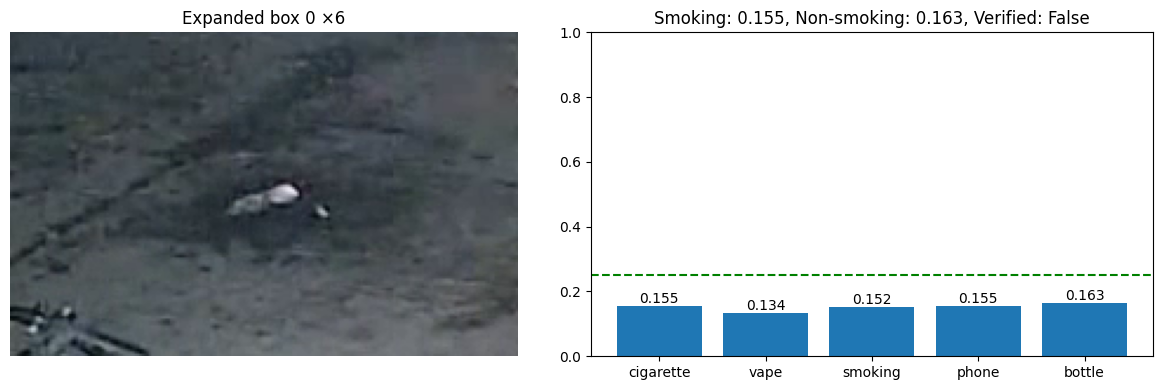

Box 0: Max smoking=0.155, Max non-smoking=0.163, Verified: False


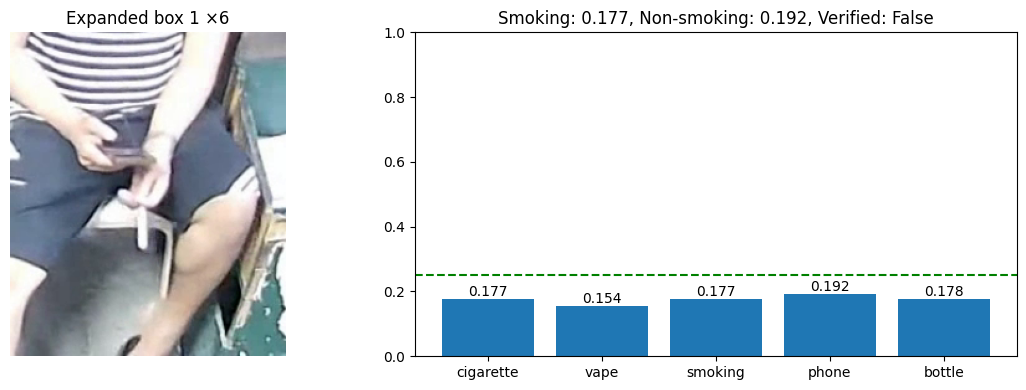

Box 1: Max smoking=0.177, Max non-smoking=0.192, Verified: False
  Processed 390 frames, active tracks: 4


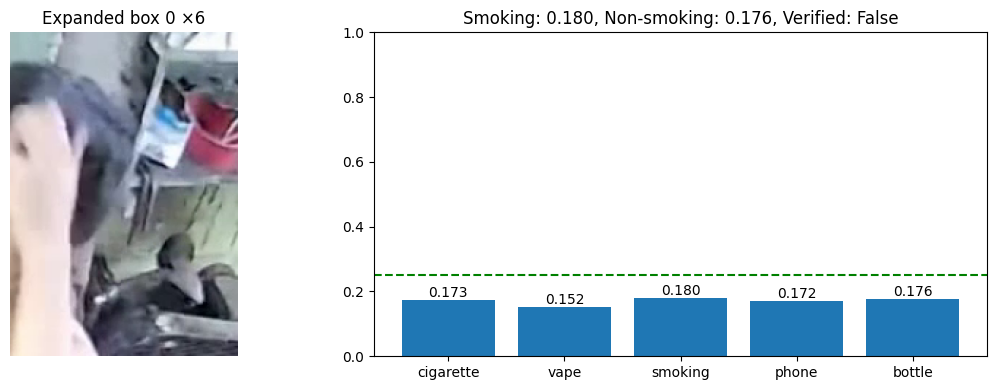

Box 0: Max smoking=0.180, Max non-smoking=0.176, Verified: False


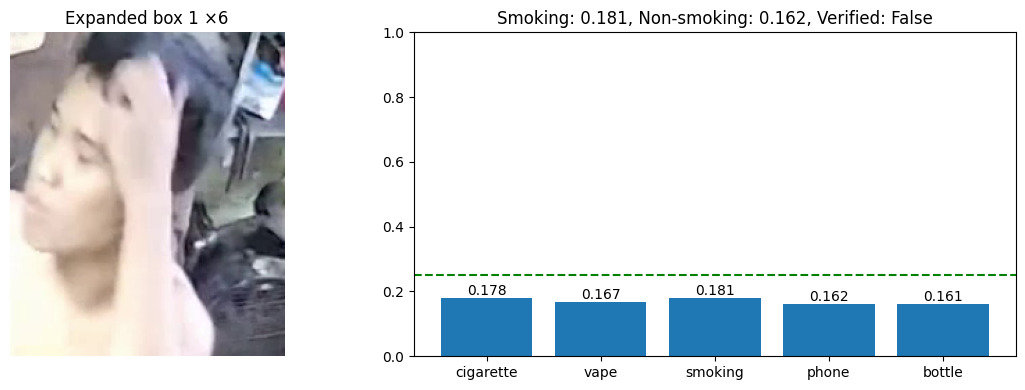

Box 1: Max smoking=0.181, Max non-smoking=0.162, Verified: False
  Processed 420 frames, active tracks: 0
  Processed 450 frames, active tracks: 1


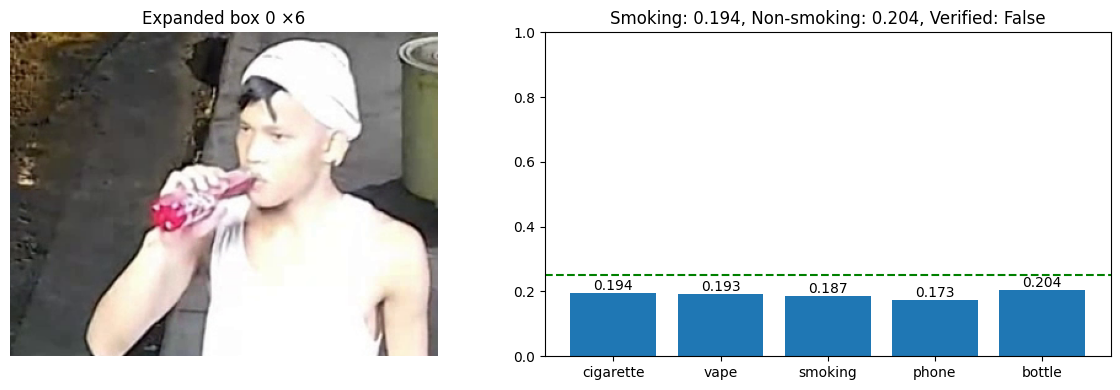

Box 0: Max smoking=0.194, Max non-smoking=0.204, Verified: False
  Processed 480 frames, active tracks: 2


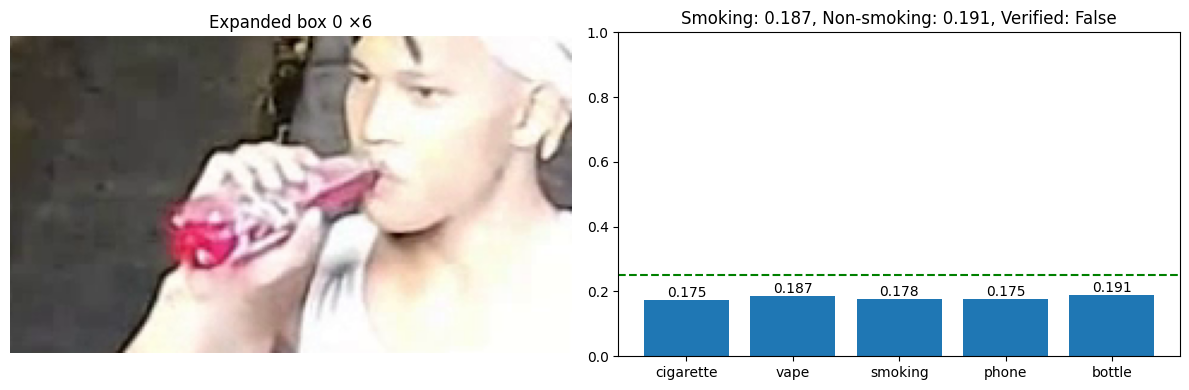

Box 0: Max smoking=0.187, Max non-smoking=0.191, Verified: False


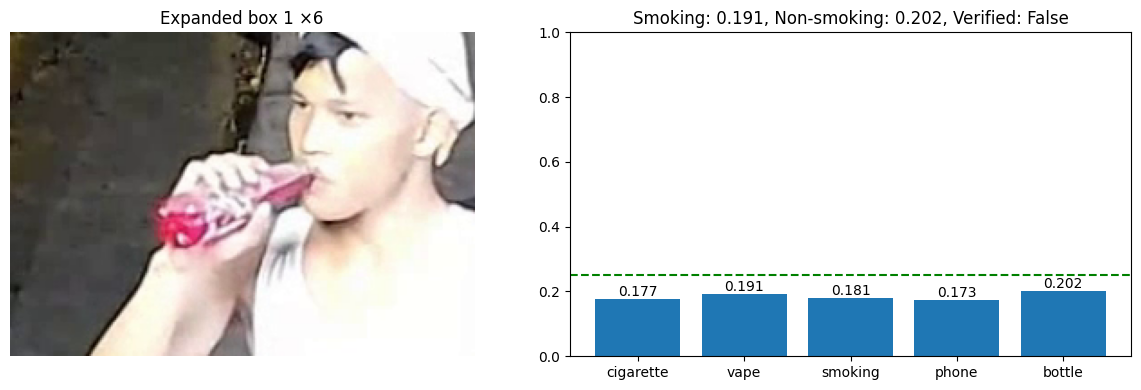

Box 1: Max smoking=0.191, Max non-smoking=0.202, Verified: False
  Processed 510 frames, active tracks: 1
  Processed 540 frames, active tracks: 0
  Processed 570 frames, active tracks: 0
  Processed 600 frames, active tracks: 0
  Processed 630 frames, active tracks: 1


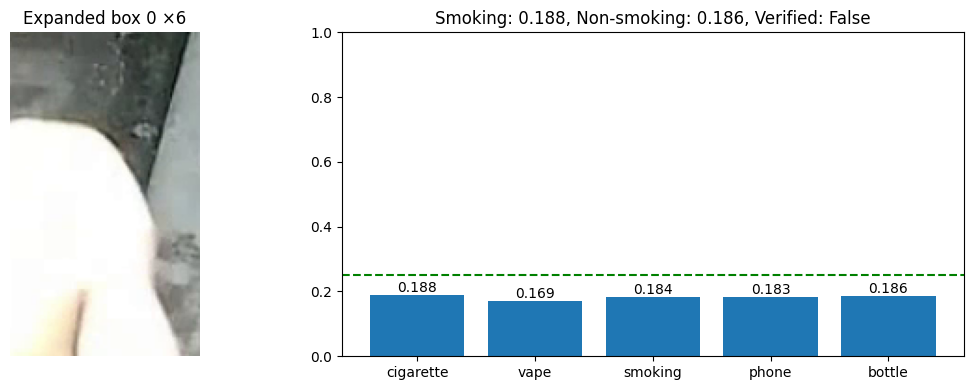

Box 0: Max smoking=0.188, Max non-smoking=0.186, Verified: False
  Processed 660 frames, active tracks: 0
Saved to: smoking/detected/detected_16.mp4
All videos processed!
CPU times: user 2min 42s, sys: 406 ms, total: 2min 43s
Wall time: 2min 40s


In [ ]:
%%time
video_files = list(input_dir.glob('*.mp4'))
for video_path in video_files:
    print(f'Processing: {video_path.name}')

    cap = cv2.VideoCapture(str(video_path))

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    output_path = output_dir / f'detected_{video_path.name}'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))

    frame_count = 0
    scale_factor = 2.0
    tracker = DetectionTracker()
    clip_check_interval = 30
    verified_tracks = {}

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        quadrants, offsets, quad_size = split_frame_into_quadrants(frame)

        all_cigarette_detections = []
        all_smoke_detections = []

        for quad_idx, (quadrant, offset) in enumerate(zip(quadrants, offsets)):
            upscaled = cv2.resize(quadrant, None, fx=scale_factor, fy=scale_factor,
                                 interpolation=cv2.INTER_CUBIC)

            cig_results = cigarette_model(upscaled, conf=0.2, verbose=False)
            smoke_results = smoke_model(upscaled, conf=0.2, verbose=False)

            cig_dets = scale_detections_to_original(cig_results, offset, scale_factor)
            smoke_dets = scale_detections_to_original(smoke_results, offset, scale_factor)

            all_cigarette_detections.extend(cig_dets)
            all_smoke_detections.extend(smoke_dets)

        merged_detections = []
        for cig_det in all_cigarette_detections:
            has_smoke_overlap = False
            max_smoke_iou = 0

            for smoke_det in all_smoke_detections:
                iou = compute_iou(cig_det['box'], smoke_det['box'])
                if iou > 0.1:
                    has_smoke_overlap = True
                    max_smoke_iou = max(max_smoke_iou, iou)

            boost_factor = 1.0
            if has_smoke_overlap:
                boost_factor = 1.0 + (0.3 * max_smoke_iou)

            merged_conf = min(cig_det['conf'] * boost_factor, 1.0)

            merged_detections.append({
                'box': cig_det['box'],
                'conf': merged_conf,
                'cls': cig_det['cls'],
                'has_smoke': has_smoke_overlap
            })

        tracked_detections = tracker.update(merged_detections)

        for track in tracked_detections:
            if 'has_smoke' not in track:
                track['has_smoke'] = False

        if frame_count % clip_check_interval == 0 and len(tracked_detections) > 0:
            boxes_to_verify = [t['box'] for t in tracked_detections if t['id'] not in verified_tracks]

            if boxes_to_verify:
                verification_results = verify_smoking_with_clip(frame, boxes_to_verify, debug=True)

                idx = 0
                for track in tracked_detections:
                    if track['id'] not in verified_tracks:
                        verified_tracks[track['id']] = verification_results[idx]
                        idx += 1

        annotated_frame = frame.copy()
        for track in tracked_detections:
            is_verified = verified_tracks.get(track['id'], True)

            if not is_verified:
                continue

            x1, y1, x2, y2 = map(int, track['box'])
            conf = track['conf']
            avg_conf = np.mean(track['conf_history'])

            temporal_boost = min(track['hits'] / 10.0, 0.2)
            final_conf = min(avg_conf + temporal_boost, 1.0)

            color = (0, 255, 0) if track['has_smoke'] else (0, 255, 255)
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)

            label = f'ID:{track["id"]} {final_conf:.2f}'
            if track['has_smoke']:
                label += ' +smoke'


            label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.rectangle(annotated_frame, (x1, y1 - label_size[1] - 10),
                          (x1 + label_size[0], y1), color, -1)
            cv2.putText(annotated_frame, label, (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        out.write(annotated_frame)
        frame_count += 1

        if frame_count % 30 == 0:
            print(f'  Processed {frame_count} frames, active tracks: {len(tracked_detections)}')

    cap.release()
    out.release()

    print(f'Saved to: {output_path}')

cv2.destroyAllWindows()
print('All videos processed!')
